In [1]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import  os
from scipy.ndimage import gaussian_filter1d
from scipy.interpolate import UnivariateSpline
from scipy.interpolate import InterpolatedUnivariateSpline


In [2]:
def load_data(path, verbose=False):
    "load un data set avec plusieurs fichiers csv"
    li = []
    for filename in os.listdir(path):
        df = pl.read_csv(path + "/" + filename)
        li.append(df)
    output = pl.concat(li)
    if verbose:
        print(output.head())
        print(f'The shape of the data is: {output.shape}')
    return output


In [3]:
df=load_data("../../challenge_data/train_tweets")
df.head()

ID,MatchID,PeriodID,EventType,Timestamp,Tweet
str,i64,i64,i64,i64,str
"""2_0""",2,0,0,1403538600000,"""RT @soccerdotcom: If #ESP beat…"
"""2_0""",2,0,0,1403538600000,"""Visit the #SITEP official web …"
"""2_0""",2,0,0,1403538600000,"""RT @soccerdotcom: If #ESP beat…"
"""2_0""",2,0,0,1403538600000,"""RT @worldsoccershop: If there …"
"""2_0""",2,0,0,1403538600000,"""RT @soccerdotcom: If #AUS beat…"


In [4]:
def add_time_sec(df):
    '''Ajoute une colonne "Seconds" représentant le temps écoulé en secondes depuis le début de chaque match 
       et supprime la colonne "Timestamp" à un df polar.'''
    
    # Calcul des timestamps initiaux par match
    first_timestamps = df.group_by("MatchID").agg(
        pl.col("Timestamp").min().alias("FirstTimestamp")
    )
    
    # Jointure pour récupérer le premier timestamp de chaque match
    df = df.join(first_timestamps, on="MatchID")
    
    # Calcul des secondes écoulées
    df = df.with_columns(
        ((pl.col("Timestamp") - pl.col("FirstTimestamp")) // 1000).alias("Seconds")
    )
    
    # Suppression des colonnes inutiles
    df = df.drop(["Timestamp", "FirstTimestamp"])
    
    return df


def df_freq_normalized(df):
    '''Crée un dataframe qui contient pour chaque seconde le nombre de tweets normalisé par le nombre moyen de tweets par seconde,
       ainsi que la moyenne de la colonne EventType.'''
    
    # Calcul des effectifs par seconde et par match
    effectifs_per_sec = df.group_by(["MatchID", "Seconds"]).agg(
        pl.count("MatchID").alias("Effectif")
    )
    
    # Calcul de la durée totale par match
    match_durations = df.group_by("MatchID").agg(
        (pl.col("Seconds").max() - pl.col("Seconds").min()).alias("MatchDuration")
    )
    
    # Calcul de la moyenne de EventType par seconde et par match
    eventtype_means = df.group_by(["MatchID", "Seconds"]).agg(
        pl.col("EventType").max().alias("EventType")
    )
    
    # Jointure des durées avec les effectifs
    effectifs_per_sec = effectifs_per_sec.join(match_durations, on="MatchID")
    
    # Jointure des moyennes de EventType
    effectifs_per_sec = effectifs_per_sec.join(eventtype_means, on=["MatchID", "Seconds"])
    
    # Normalisation des effectifs par match, puis multiplication par la durée
    effectifs_per_sec = effectifs_per_sec.with_columns(
        ((pl.col("Effectif") / pl.col("Effectif").sum().over("MatchID")) * pl.col("MatchDuration"))
        .alias("Effectif_Normalisé")
    )
    
    return effectifs_per_sec







df_sec = add_time_sec(df)

df_freq=freq_normalized(df_sec).sort(["MatchID", "Seconds"])
df_freq.head(10)






MatchID,Seconds,Effectif,MatchDuration,EventType,Effectif_Normalisé
i64,i64,u32,i64,i64,f64
0,0,2,7800,0,0.375551
0,1,1,7800,0,0.187775
0,2,12,7800,0,2.253304
0,3,3,7800,0,0.563326
0,4,4,7800,0,0.751101
0,5,7,7800,0,1.314427
0,6,6,7800,0,1.126652
0,7,3,7800,0,0.563326
0,8,2,7800,0,0.375551


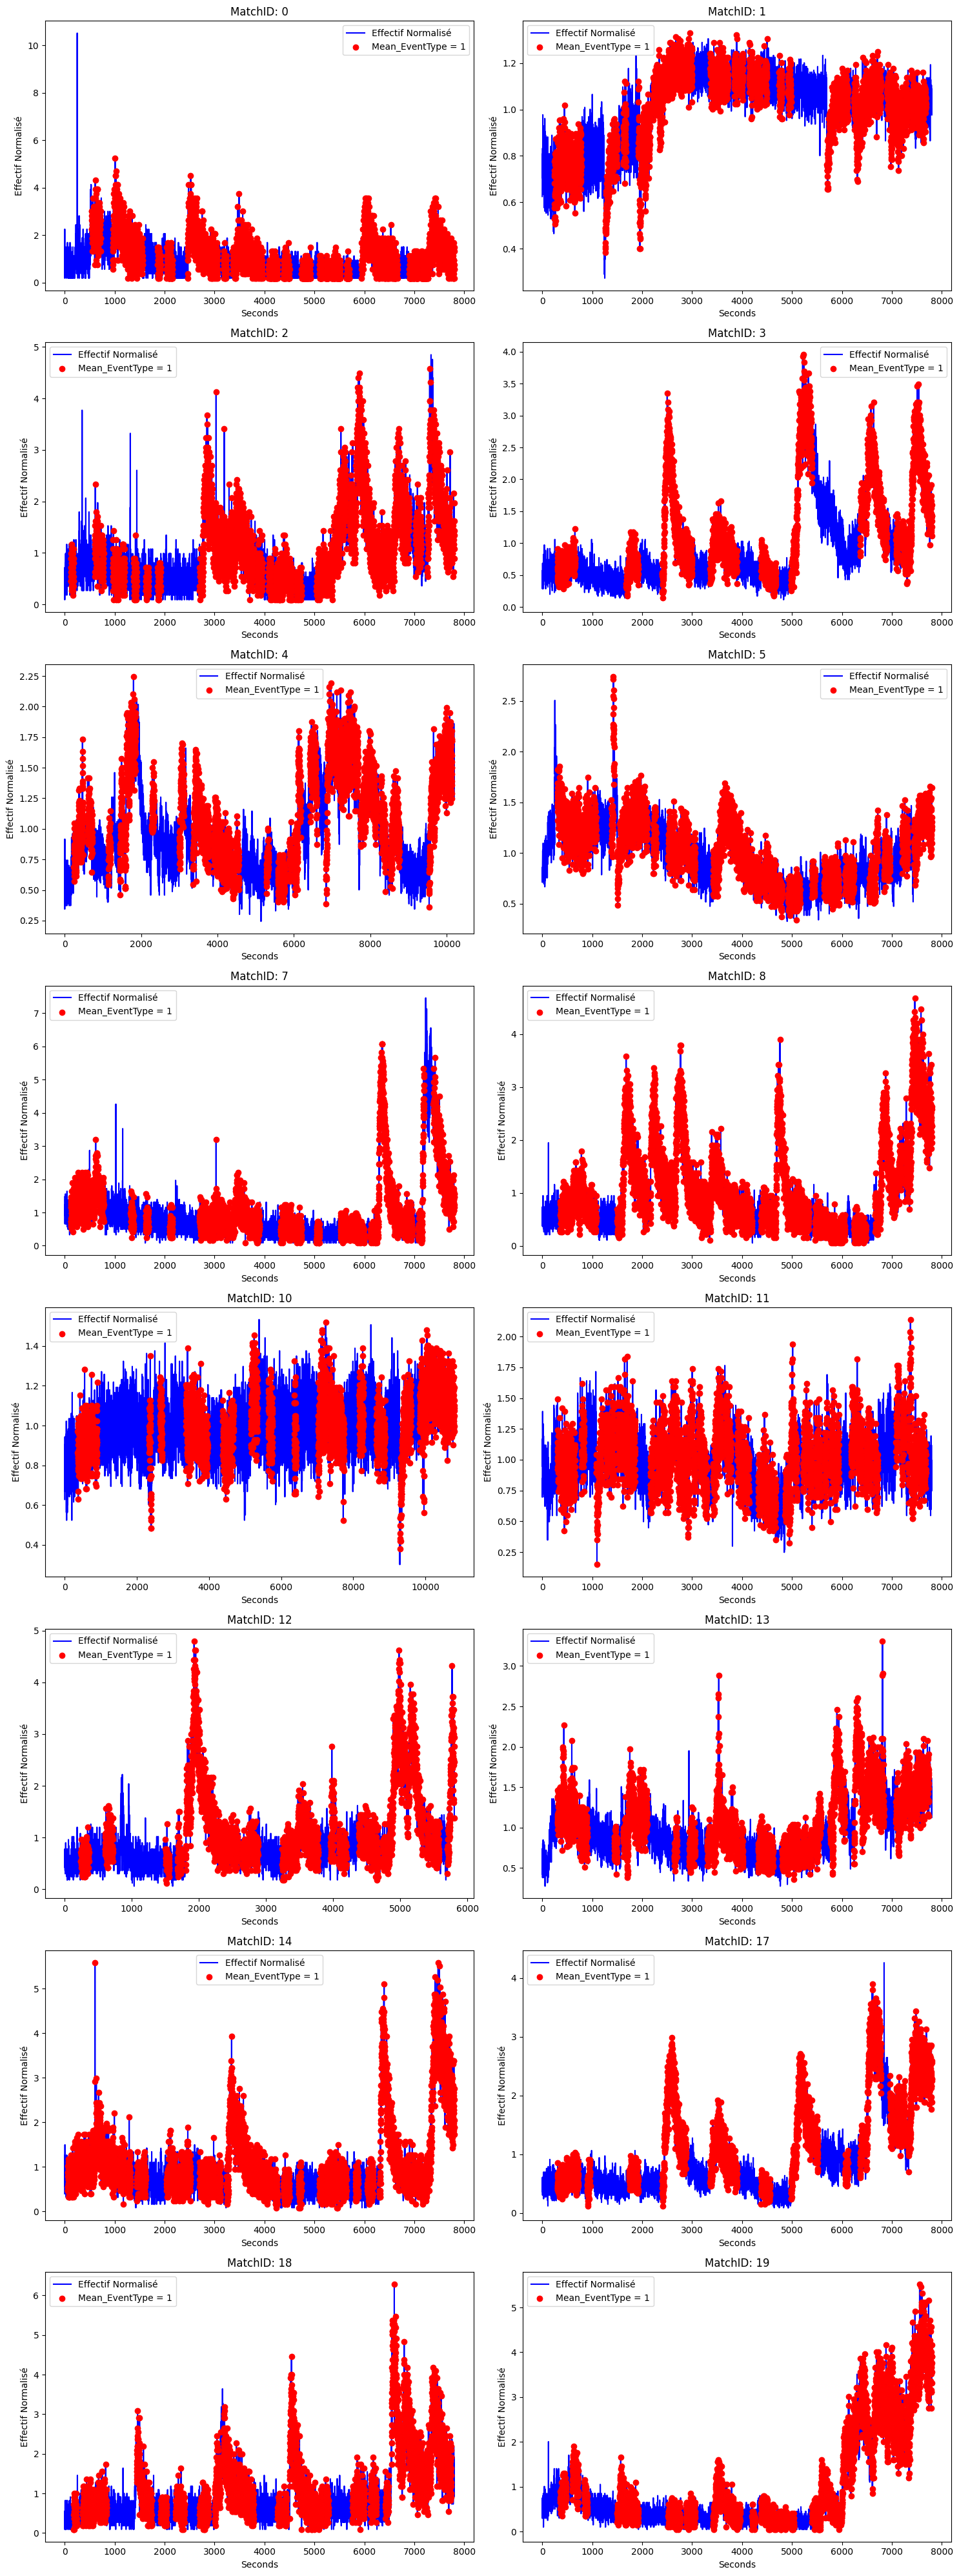

In [5]:
# Convertir le DataFrame Polars en DataFrame Pandas pour faciliter le traçage
df_pandas = df_freq.to_pandas()

# Liste unique des MatchID
match_ids = df_pandas['MatchID'].unique()

# Configuration de la grille de sous-plots
n_matches = len(match_ids)
cols = 2  # Nombre de colonnes dans la grille
rows = (n_matches + cols - 1) // cols  # Calcul dynamique des lignes nécessaires

fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 5), squeeze=False)

# Tracer chaque match dans un subplot différent
for idx, match_id in enumerate(match_ids):
    ax = axes[idx // cols, idx % cols]  # Choisir l'axe correspondant
    match_data = df_pandas[df_pandas['MatchID'] == match_id]

    # Tracer l'Effectif_Normalisé en fonction des secondes
    ax.plot(
        match_data['Seconds'],
        match_data['Effectif_Normalisé'],
        label='Effectif Normalisé',
        color='blue'
    )

    # Ajouter les points où Mean_EventType == 1
    points = match_data[match_data['EventType'] == 1]
    ax.scatter(
        points['Seconds'],
        points['Effectif_Normalisé'],
        color='red',
        label='Mean_EventType = 1',
        zorder=5
    )

    # Configurer les détails du subplot
    ax.set_title(f"MatchID: {match_id}")
    ax.set_xlabel("Seconds")
    ax.set_ylabel("Effectif Normalisé")
    ax.legend()

# Supprimer les sous-plots vides
for idx in range(n_matches, rows * cols):
    fig.delaxes(axes[idx // cols, idx % cols])

# Ajuster la mise en page
plt.tight_layout()
plt.show()


In [6]:
def apply_kernel(df_freq, kernel):
    '''Applique un noyau de convolution à la colonne "Effectif_Normalisé" du dataframe df_freq.'''
    
    effectifs = df_freq['Effectif_Normalisé'].to_numpy()
    effectifs_conv = np.convolve(effectifs, kernel, mode='same')
    df2 = df_freq.clone()
    #ajoute une colonne avec les effectifs convolués
    df2=df2.with_columns( pl.Series(effectifs_conv).alias("Effectif_Conv"))
    return df2

import numpy as np

def smoothed_derivative_kernel(scale, sigma):
    """
    Creates a 1D kernel that combines smoothing (Gaussian blur) and derivative at a given scale.

    Parameters:
    - scale (int): The size of the kernel. Must be odd.
    - sigma (float): The standard deviation of the Gaussian for smoothing.

    Returns:
    - numpy.ndarray: The 1D smoothed derivative kernel.
    """
    if scale % 2 == 0:
        raise ValueError("Scale must be an odd number.")

    # Generate positions symmetrically around 0
    n = scale // 2
    x = np.arange(-n, n + 1)

    # Gaussian function
    gaussian = np.exp(-x**2 / (2 * sigma**2))
    gaussian /= gaussian.sum()  # Normalize the Gaussian

    # Derivative of Gaussian
    derivative_gaussian = -x * gaussian / sigma**2

    return derivative_gaussian

N=20
scale = 2*N+1 # Size of the kernel (must be odd)
sigma = 15  # Standard deviation for smoothing
ker = smoothed_derivative_kernel(scale, sigma)

df_freq_conv = apply_kernel(df_freq, ker)
df_freq_conv.head(100)

MatchID,Seconds,Effectif,MatchDuration,EventType,Effectif_Normalisé,Effectif_Conv
i64,i64,u32,i64,i64,f64,f64
0,0,2,7800,0,0.375551,0.014054
0,1,1,7800,0,0.187775,0.014016
0,2,12,7800,0,2.253304,0.014105
0,3,3,7800,0,0.563326,0.013449
0,4,4,7800,0,0.751101,0.013352
…,…,…,…,…,…,…
0,100,1,7800,0,0.187775,-0.001194
0,101,3,7800,0,0.563326,0.000665
0,102,3,7800,0,0.563326,0.001013


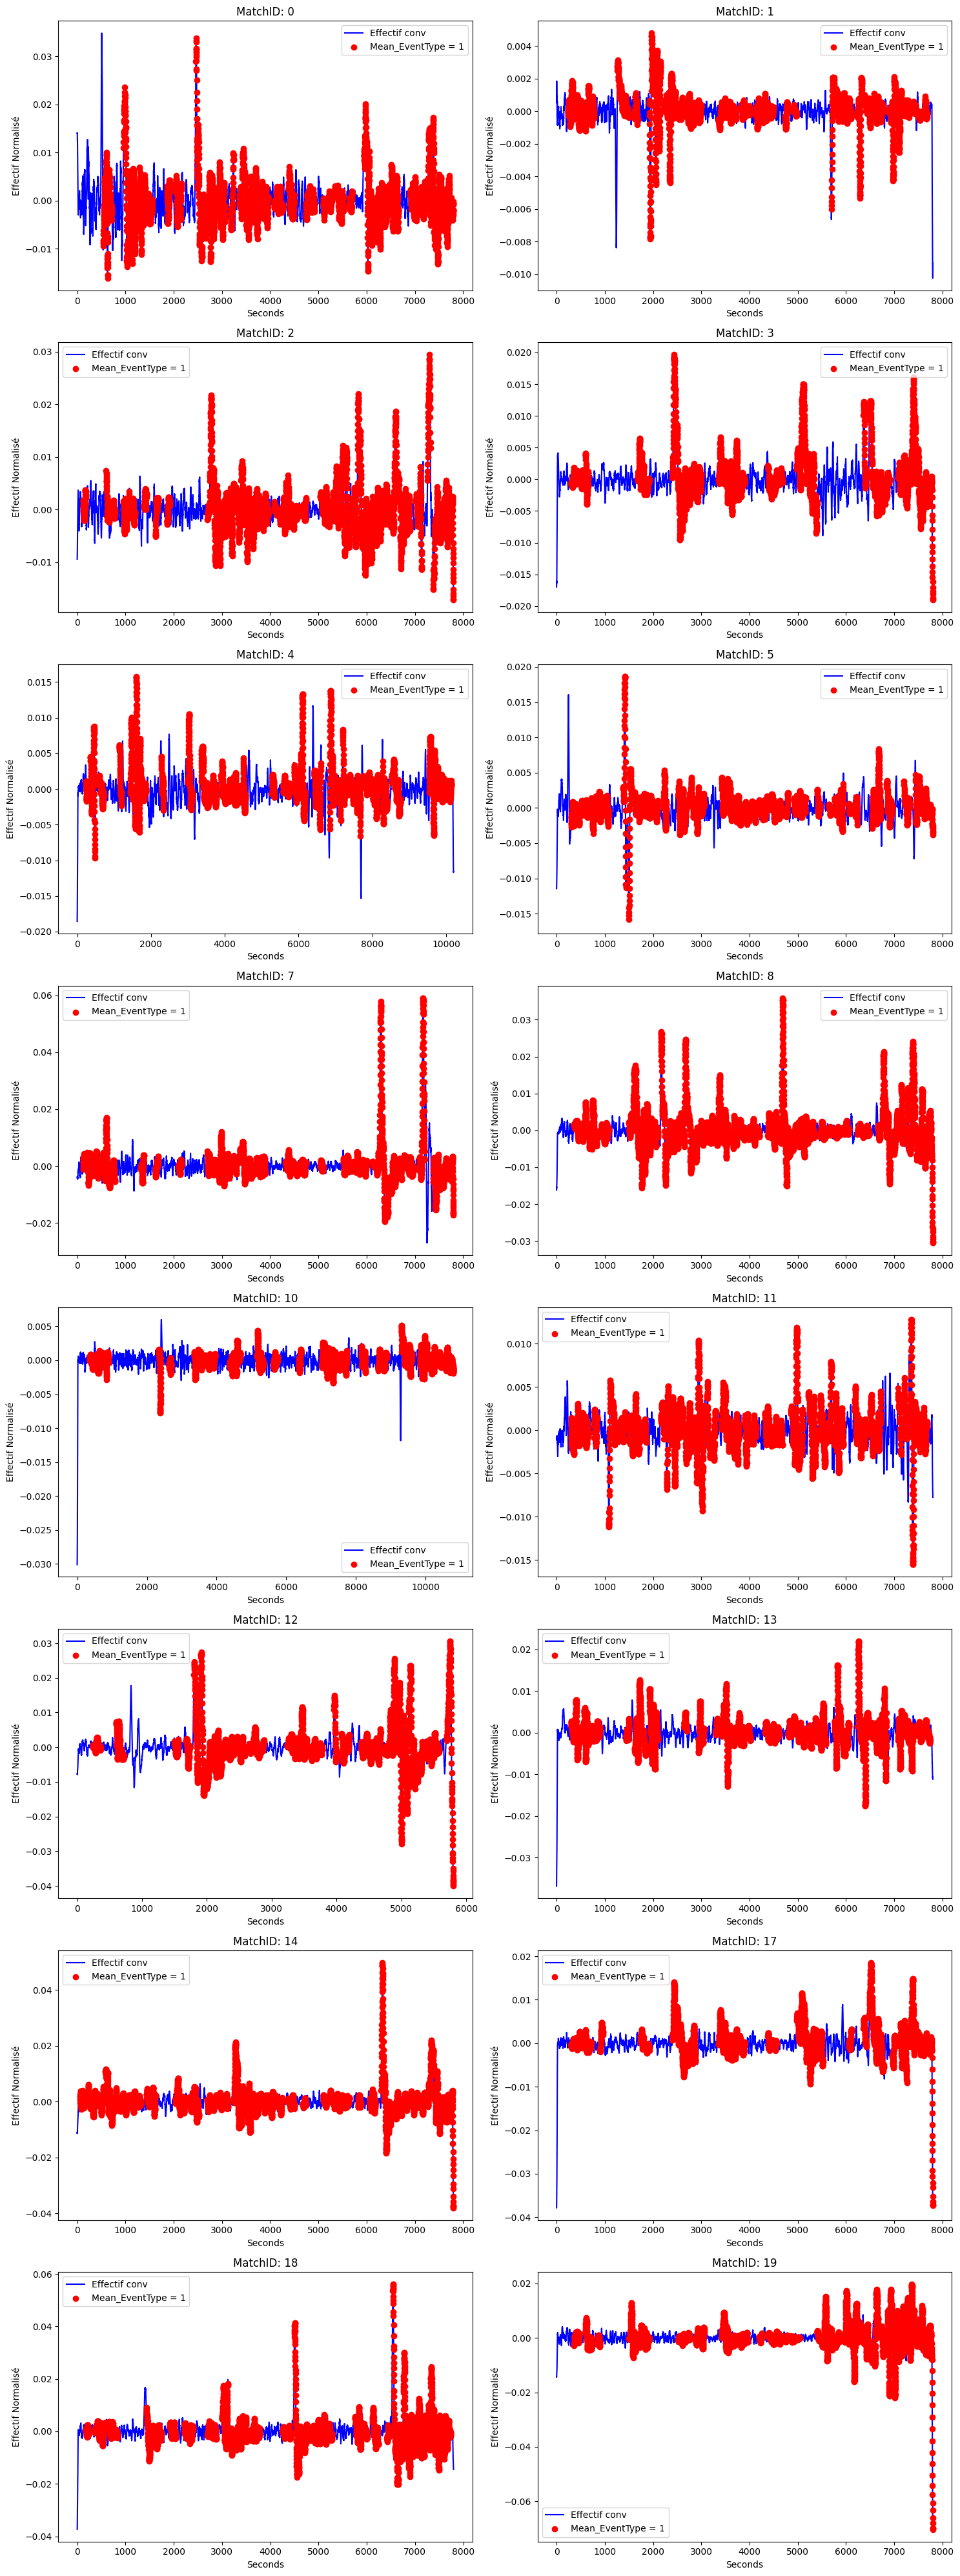

In [7]:
# Convertir le DataFrame Polars en DataFrame Pandas pour faciliter le traçage
df_pandas = df_freq_conv.to_pandas()

# Liste unique des MatchID
match_ids = df_pandas['MatchID'].unique()

# Configuration de la grille de sous-plots
n_matches = len(match_ids)
cols = 2  # Nombre de colonnes dans la grille
rows = (n_matches + cols - 1) // cols  # Calcul dynamique des lignes nécessaires

fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 5), squeeze=False)

# Tracer chaque match dans un subplot différent
for idx, match_id in enumerate(match_ids):
    ax = axes[idx // cols, idx % cols]  # Choisir l'axe correspondant
    match_data = df_pandas[df_pandas['MatchID'] == match_id]

    # Tracer l'Effectif_Normalisé en fonction des secondes
    ax.plot(
        match_data['Seconds'],
        match_data['Effectif_Conv'],
        label='Effectif conv',
        color='blue'
    )

    # Ajouter les points où Mean_EventType == 1
    points = match_data[match_data['EventType'] == 1]
    ax.scatter(
        points['Seconds'],
        points['Effectif_Conv'],
        color='red',
        label='Mean_EventType = 1',
        zorder=5
    )

    # Configurer les détails du subplot
    ax.set_title(f"MatchID: {match_id}")
    ax.set_xlabel("Seconds")
    ax.set_ylabel("Effectif Normalisé")
    ax.legend()

# Supprimer les sous-plots vides
for idx in range(n_matches, rows * cols):
    fig.delaxes(axes[idx // cols, idx % cols])

# Ajuster la mise en page
plt.tight_layout()
plt.show()


## tests de diffétentes features

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider, FloatSlider

# Normalisation des colonnes
def normalize_column(col):
    return (col - col.mean()) / col.std()

# Calcul des features
def compute_features_per_match(df, window_size=10):
    """
    Calcule des features basées sur les séries temporelles pour chaque MatchID séparément.
    :param df: DataFrame d'entrée contenant 'Effectif_Normalisé', 'MatchID', et 'EventType'.
    :param window_size: Taille de la fenêtre glissante pour calculer les features.
    :return: DataFrame avec les nouvelles features.
    """

    def compute_fft_features(group):
        # Transformée de Fourier pour un groupe
        freqs = np.fft.rfft(group['Effectif_Normalisé'].fillna(0))
        group['fft_energy_total'] = np.sum(np.abs(freqs)**2)  # Énergie totale
        group['fft_peak_freq'] = np.argmax(np.abs(freqs))  # Indice de la fréquence dominante
        return group

    # Appliquer les calculs de FFT par groupe MatchID
    df = df.groupby('MatchID').apply(compute_fft_features).reset_index(drop=True)

    # Moyenne glissante
    df[f'mean_{window_size}'] = (
        df.groupby('MatchID')['Effectif_Normalisé']
        .rolling(window=window_size, min_periods=1)
        .mean()
        .reset_index(0, drop=True)
    )

    # Variance glissante
    df[f'var_{window_size}'] = (
        df.groupby('MatchID')['Effectif_Normalisé']
        .rolling(window=window_size, min_periods=1)
        .var()
        .reset_index(0, drop=True)
    )

    # Dérivée première (taux de changement)
    df['derivative'] = df.groupby('MatchID')['Effectif_Normalisé'].diff().fillna(0)

    # Somme cumulative par MatchID
    df['cumsum'] = df.groupby('MatchID')['Effectif_Normalisé'].cumsum()

    # Normaliser les features
    for col in [f'mean_{window_size}', f'var_{window_size}', 'derivative', 'cumsum', 'fft_energy_total']:
        df[col] = normalize_column(df[col])

    return df

# Évaluation des features
def evaluate_features(df, feature_columns, target='EventType'):
    """
    Évalue la pertinence des features en calculant leur corrélation normalisée avec le label.
    :param df: DataFrame contenant les features et la target.
    :param feature_columns: Liste des colonnes de features à évaluer.
    :param target: Nom de la colonne cible (label).
    :return: DataFrame avec les scores de corrélation.
    """
    correlations = {}
    for col in feature_columns:
        correlations[col] = df[col].corr(df[target])

    # Trier les résultats par pertinence décroissante
    return pd.DataFrame.from_dict(correlations, orient='index', columns=['Correlation']).sort_values(by='Correlation', ascending=False)

# Widgets pour ajuster les paramètres
def interactive_feature_creation(df):
    """
    Interface interactive pour ajuster les paramètres des features et évaluer les corrélations.
    :param df: DataFrame d'entrée.
    """
    def update(window_size):
        # Calculer les features avec le nouveau paramètre
        features_df = compute_features_per_match(df, window_size=window_size)

        # Évaluer les corrélations
        features_to_evaluate = [
            col for col in features_df.columns 
            if col not in ['MatchID', 'Seconds', 'EventType', 'Effectif', 'MatchDuration', 'Effectif_Normalisé']
        ]
        correlations = evaluate_features(features_df, features_to_evaluate)

        # Afficher les résultats
        print(f"Corrélations pour une fenêtre de {window_size} secondes :")
        print(correlations)
        
        # Tracer un exemple de feature
        plot_feature(features_df, feature=f'mean_{window_size}', title=f"Moyenne glissante (window={window_size})")
    
    interact(update, window_size=IntSlider(min=5, max=60, step=5, value=10))

# Tracer une feature
def plot_feature(df, feature, title="Feature Plot"):
    """
    Trace une feature en fonction du temps pour visualisation.
    :param df: DataFrame contenant la feature.
    :param feature: Nom de la colonne feature à tracer.
    :param title: Titre du graphique.
    """
    plt.figure(figsize=(12, 6))
    plt.plot(df['Seconds'], df[feature], label=feature)
    plt.xlabel('Seconds')
    plt.ylabel(feature)
    plt.title(title)
    plt.legend()
    plt.show()

# Exemple d'utilisation
# Charger votre DataFrame
# df = pd.read_csv('votre_fichier.csv')

# Si vous travaillez avec un autre format comme Polars, convertir d'abord
df_pandas = df_freq.to_pandas()

# Lancer l'interface interactive
interactive_feature_creation(df_pandas)


interactive(children=(IntSlider(value=10, description='window_size', max=60, min=5, step=5), Output()), _dom_c…

## Pipline pour concevoir et évaluer les features

KeyError: -1

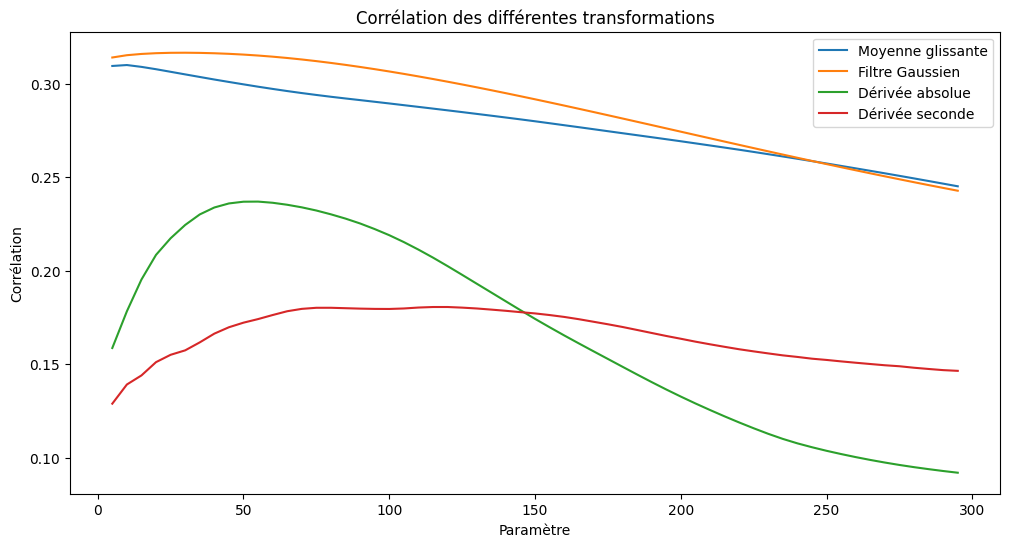

In [11]:
df_pandas = df_freq.to_pandas()




def evaluate_f(df, f, params_f):
    """
    Évalue la pertinence d'une fonction f avec des paramètres params_f sur un DataFrame df.
    :param df: DataFrame Pandas contenant les colonnes nécessaires.
    :param f: Fonction de transformation appliquée aux données.
    :param params_f: Paramètres à passer à la fonction f (liste).
    :return: Corrélation de Pearson entre la transformation et EventType.
    """
    frequences = df["Effectif_Normalisé"].to_numpy()  # Array numpy
    result = f(frequences, params_f)  # Déballer les paramètres (liste -> arguments)

    # Vérifier la longueur pour éviter des erreurs
    if len(result) != len(df["EventType"]):
        raise ValueError("La longueur du résultat de la fonction f ne correspond pas à la taille des données.")

    # Calculer la corrélation de Pearson
    correlation = np.corrcoef(result, df["EventType"])[0, 1]
    return correlation



def moyenne_glissante(array, Lwindow_size):
    """
    Calcule la moyenne glissante des effectifs normalisés sur un array.
    :param array: Array 1D d'entrée.
    :param window_size: Taille de la fenêtre glissante (entier).
    :return: Array 1D des moyennes glissantes.
    """
    window_size = Lwindow_size[0]
    n = len(array)
    result = np.empty(n)  # Crée un tableau pour stocker les résultats

    # Calcul des moyennes pour les fenêtres complètes
    cumsum = np.cumsum(np.insert(array, 0, 0))  # Cumsum avec un zéro initial
    result[window_size - 1:] = (cumsum[window_size:] - cumsum[:-window_size]) / window_size

    # Calcul des moyennes pour les bords (début et fin)
    for i in range(window_size - 1):
        result[i] = cumsum[i + 1] / (i + 1)  # Moyenne début
        result[-i - 1] = (cumsum[-1] - cumsum[-i - 2]) / (i + 1)  # Moyenne fin

    return result



def derivee_gaussian_abs(array, Lsigma):
    """
    Calcule la dérivée discrète d'un signal bruité après un flou gaussien.
    :param signal: Array 1D du signal d'entrée.
    :param delta_t: Intervalle de temps entre deux points.
    :param sigma: Écart-type du flou gaussien.
    :return: Array 1D représentant la dérivée lissée.
    """
    # Appliquer le flou gaussien
    sigma = Lsigma[0]
    signal_lissé = gaussian_filter1d(array, sigma)

    # Calcul des différences centrées pour la dérivée
    n = len(array)
    derivative = np.empty(n)

    if n > 2:
        # Différence centrée pour les points internes
        derivative[1:-1] = (signal_lissé[2:] - signal_lissé[:-2]) / 2

        # Différences unilatérales pour les bords
        derivative[0] = (signal_lissé[1] - signal_lissé[0]) 
        derivative[-1] = (signal_lissé[-1] - signal_lissé[-2]) 
    elif n == 2:
        derivative[0] = (signal_lissé[1] - signal_lissé[0])
        derivative[1] = (signal_lissé[1] - signal_lissé[0])
    else:
        derivative[0] = 0

    return np.abs(derivative)

def derivee_seg_gaussian(array, Lsigma):
    """
    Calcule la dérivée seconde d'un signal bruité après un flou gaussien.
    :param array: Array 1D du signal d'entrée.
    :param Lsigma: Liste contenant l'écart-type du flou gaussien (sigma).
    :return: Array 1D représentant la dérivée seconde gaussienne.
    """
    sigma = Lsigma[0]  # Écart-type du flou gaussien
    n=len(array)

    # Appliquer le flou gaussien pour lisser le signal
    signal_lissé = gaussian_filter1d(array, sigma)
    second_derivative = np.empty(n)
    if n > 2:
        # Différence centrée pour les points internes
        second_derivative[1:-1] = (signal_lissé[2:] - 2 * signal_lissé[1:-1] + signal_lissé[:-2])

        # Différences unilatérales pour les bords
        second_derivative[0] = (signal_lissé[2] - 2 * signal_lissé[1] + signal_lissé[0])
        second_derivative[-1] = (signal_lissé[-1] - 2 * signal_lissé[-2] + signal_lissé[-3])
    elif n == 2:
        second_derivative[0] = (signal_lissé[1] - 2 * signal_lissé[0] + signal_lissé[1])
        second_derivative[1] = (signal_lissé[1] - 2 * signal_lissé[0] + signal_lissé[1])
    else:
        second_derivative[0] = 0
        second_derivative[0] = 0  # or some other appropriate value

    if n > 3:
        second_derivative[-1] = (signal_lissé[-1] - 2 * signal_lissé[-2] + signal_lissé[-3])
    else:
        second_derivative[-1] = 0  # or some other appropriate value

    return np.abs(second_derivative)

def gaussian_filter(array, Lsigma):
    """
    Applique un filtre gaussien à un array 1D.
    :param array: Array 1D d'entrée.
    :param sigma: Écart-type du filtre gaussien.
    :return: Array 1D filtré.
    """
    sigma = Lsigma[0]
    return gaussian_filter1d(array, sigma)

def derivee_seconde_spline_padding(array, Ls=[0.5]):
    """
    Calcule la dérivée seconde d'un signal bruité en ajustant un spline de lissage,
    avec un padding dont la taille est proportionnelle à s.
    :param array: Array 1D du signal d'entrée.
    :param x: Array 1D des points correspondants (optionnel, sinon indices utilisés).
    :param s: Degré de lissage (plus grand = plus lisse, contrôle aussi la taille du padding).
    :return: Array 1D représentant la dérivée seconde calculée (sans padding).
    """
    s=Ls[0]
    x = np.arange(len(array))

    # Calcul dynamique de la taille du padding en fonction de s
    padding = int(4 * s)  # Taille proportionnelle à s

    # Extrapolation linéaire pour le padding
    x_ext = np.concatenate((
        np.linspace(x[0] - padding * (x[1] - x[0]), x[0], padding, endpoint=False),
        x,
        np.linspace(x[-1], x[-1] + padding * (x[1] - x[0]), padding, endpoint=False)
    ))
    array_ext = np.concatenate((
        np.full(padding, array[0]),  # Padding gauche avec la valeur initiale
        array,
        np.full(padding, array[-1])  # Padding droit avec la valeur finale
    ))

    # Ajuster un spline de lissage sur les données étendues
    spline = UnivariateSpline(x_ext, array_ext, s=s)

    # Calcul de la dérivée seconde sur les points originaux
    second_derivative = spline.derivative(n=2)(x)
    return second_derivative


evaluate_f(df_pandas, moyenne_glissante, [11])

windows=np.arange(5, 300, 5)
ss=np.arange(0.1, 1, 0.1)
corr_moy= [evaluate_f(df_pandas, moyenne_glissante, [window]) for window in windows]
corr_gauss= [evaluate_f(df_pandas, gaussian_filter, [sigma]) for sigma in windows]
corr_der= [evaluate_f(df_pandas, derivee_gaussian, [window]) for window in windows]
corr_der_seg= [evaluate_f(df_pandas, derivee_seg_gaussian, [sigma]) for sigma in windows]


plt.figure(figsize=(12, 6))
plt.plot(windows, corr_moy, label='Moyenne glissante')
plt.plot(windows, corr_gauss, label='Filtre Gaussien')
plt.plot(windows, corr_der, label='Dérivée absolue')
plt.plot(windows, corr_der_seg, label='Dérivée seconde')
plt.xlabel('Paramètre')
plt.ylabel('Corrélation')
plt.title('Corrélation des différentes transformations')
plt.legend()

print(np.corrcoef(derivee_seconde_spline_padding(df_pandas["Effectif_Normalisé"], df_pandas["EventType"])[0, 1]))
print(np.corrcoef(df_pandas["Effectif_Normalisé"], df_pandas["EventType"])[0, 1])